# Advanced BigData Project 2 - ETL based on TPC-DI

# About the Project:

### Source and required files:
http://www.tpc.org/

Download the source code of `TPC-DI` and use it to generate the files.

### Documentation:

http://www.tpc.org/tpc_documents_current_versions/pdf/tpc-di_v1.1.0.pdf

### Notes:

This Project will handle a part of the ETL process using the generated files that represent the different sources of data by implementing a ETL in Staging area to Data Warehouse (Star Schema) and then implement a simple tasks (Queries) on the final data.

**In our scenario:**
- We will use PySpark (DataFrames, Spark SQL).
- We will work on Historical Load (Batch1) only.
- Not all Historical Load will be included in our scenario.
- The Surrogate keys will be considerd as same as ID (will not generate key for record).

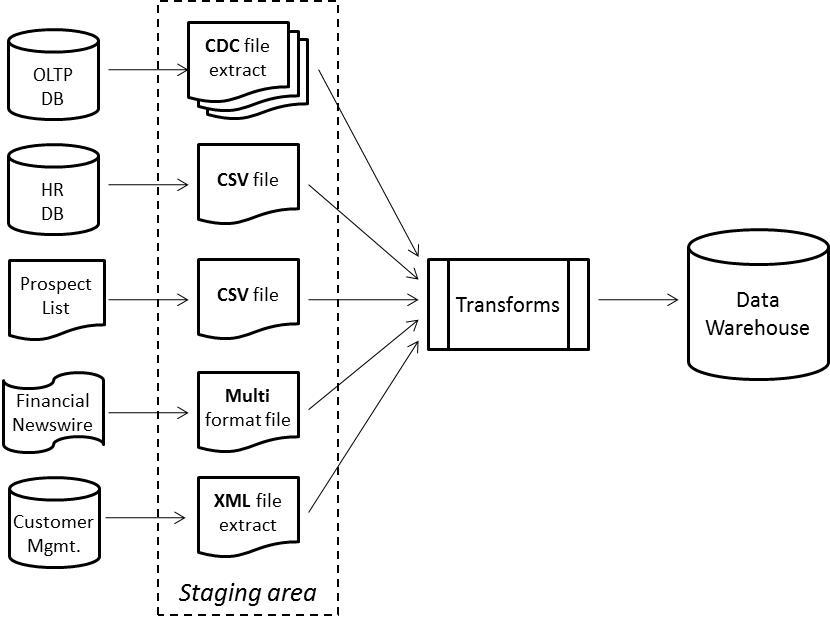

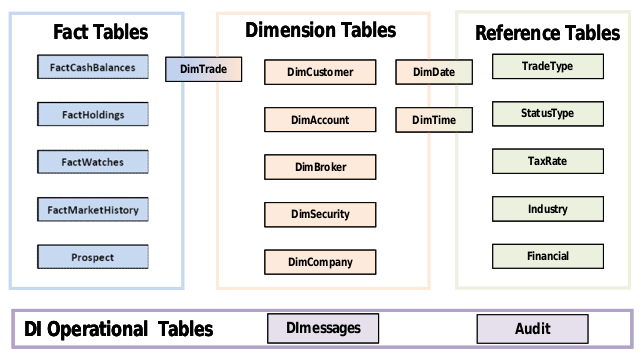

# Import required packages

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, broadcast, lit, upper, coalesce
from pyspark.sql.types import *
from IPython.display import Image
import xml.etree.ElementTree as ET

# Initiate spark session

In [2]:
conf = SparkConf().setAppName("ETL based on TPC-DI")

sc = SparkContext(conf=conf)

spark = SparkSession(sc) \
    .builder \
    .getOrCreate()

# Staging area (ETL)

## BatchDate

In [3]:
StagingBatchDate_schema = StructType([
    StructField("Date", StringType()),
])

StagingBatchDate = spark.read \
                        .format('csv') \
                        .schema(StagingBatchDate_schema) \
                        .load("./Batch1/BatchDate.txt")

BatchDate = StagingBatchDate.take(1)[0][0]

BatchDate

'2017-07-07'

## Preparing Warehous Reference Tables

### StatusType

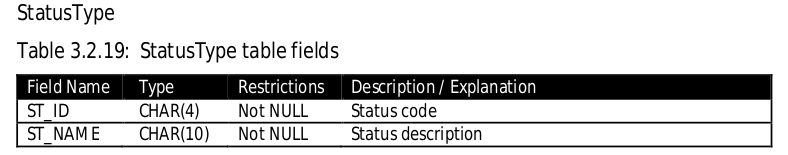

In [4]:
Image(filename="./pic/StatusType.png")

In [5]:
StatusType_schema = StructType([
    StructField("ST_ID", StringType(), False),
    StructField("ST_NAME", StringType(), False),
])

StatusType = spark.read\
                .format("csv")\
                .option("delimiter", "|") \
                .schema(StatusType_schema) \
                .load("./Batch1/StatusType.txt")

In [6]:
StatusType.printSchema()

root
 |-- ST_ID: string (nullable = true)
 |-- ST_NAME: string (nullable = true)



In [7]:
StatusType.show(5)

+-----+---------+
|ST_ID|  ST_NAME|
+-----+---------+
| ACTV|   Active|
| CMPT|Completed|
| CNCL| Canceled|
| PNDG|  Pending|
| SBMT|Submitted|
+-----+---------+
only showing top 5 rows



### TaxRate

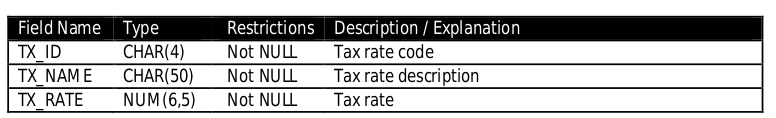

In [8]:
Image(filename="./pic/TaxRate.png")

In [9]:
TaxRate_schema = StructType([
    StructField("TX_ID", StringType(), False),
    StructField("TX_NAME", StringType(), False),
    StructField("TX_RATE", FloatType(), False),
])

TaxRate = spark.read\
                .format("csv")\
                .option("delimiter", "|") \
                .schema(TaxRate_schema) \
                .load("./Batch1/TaxRate.txt")

In [10]:
TaxRate.printSchema()

root
 |-- TX_ID: string (nullable = true)
 |-- TX_NAME: string (nullable = true)
 |-- TX_RATE: float (nullable = true)



In [11]:
TaxRate.show(5)

+-----+--------------------+-------+
|TX_ID|             TX_NAME|TX_RATE|
+-----+--------------------+-------+
|  US1|U.S. Income Tax B...|   0.15|
|  US2|U.S. Income Tax B...|  0.275|
|  US3|U.S. Income Tax B...|  0.305|
|  US4|U.S. Income Tax B...|  0.355|
|  US5|U.S. Income Tax B...|  0.391|
+-----+--------------------+-------+
only showing top 5 rows



### Prospect

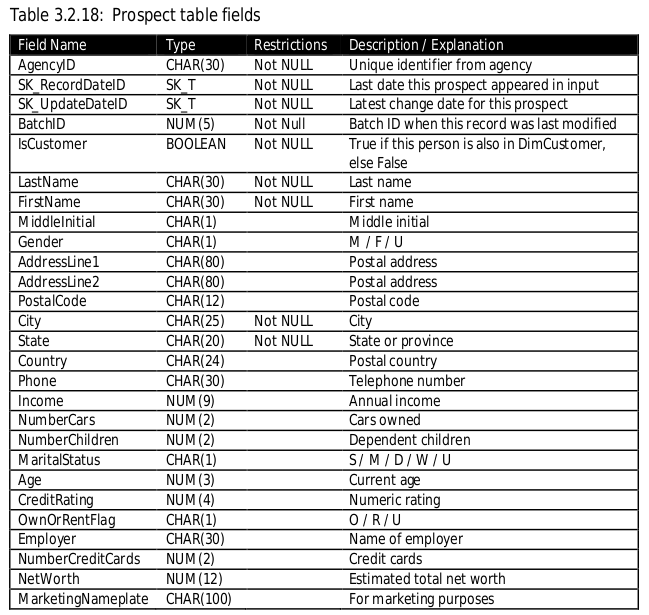

In [12]:
Image(filename="./pic/Prospect.png")

In [13]:
Prospect_schema = StructType([
    StructField("AgencyID", StringType(), False),
    StructField("LastName", StringType(), False),
    StructField("FirstName", StringType(), False),
    StructField("MiddleInitial", StringType()),
    StructField("Gender", StringType()),
    StructField("AddressLine1", StringType()),
    StructField("AddressLine2", StringType()),
    StructField("PostalCode", StringType()),
    StructField("City", StringType(), False),
    StructField("State", StringType(), False),
    StructField("Country", StringType()),
    StructField("Phone", StringType()),
    StructField("Income", IntegerType()),
    StructField("NumberCars", IntegerType()),
    StructField("NumberChildren", IntegerType()),
    StructField("MaritalStatus", StringType()),
    StructField("Age", IntegerType()),
    StructField("CreditRating", IntegerType()),
    StructField("OwnOrRentFlag", StringType()),
    StructField("Employer", StringType()),
    StructField("NumberCreditCards", IntegerType()),
    StructField("NetWorth", IntegerType()),
])

Prospect = spark.read\
                .format("csv")\
                .option("delimiter", ",") \
                .option('header', 'false') \
                .schema(Prospect_schema) \
                .load("./Batch1/Prospect.csv")

In [14]:
print(Prospect.count())
Prospect.printSchema()

49940
root
 |-- AgencyID: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- MiddleInitial: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- AddressLine2: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Phone: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- NumberCars: integer (nullable = true)
 |-- NumberChildren: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- CreditRating: integer (nullable = true)
 |-- OwnOrRentFlag: string (nullable = true)
 |-- Employer: string (nullable = true)
 |-- NumberCreditCards: integer (nullable = true)
 |-- NetWorth: integer (nullable = true)



In [15]:
Prospect.show(1)

+--------+--------+---------+-------------+------+--------------------+------------+----------+--------+-----+-------+--------------+------+----------+--------------+-------------+---+------------+-------------+--------+-----------------+--------+
|AgencyID|LastName|FirstName|MiddleInitial|Gender|        AddressLine1|AddressLine2|PostalCode|    City|State|Country|         Phone|Income|NumberCars|NumberChildren|MaritalStatus|Age|CreditRating|OwnOrRentFlag|Employer|NumberCreditCards|NetWorth|
+--------+--------+---------+-------------+------+--------------------+------------+----------+--------+-----+-------+--------------+------+----------+--------------+-------------+---+------------+-------------+--------+-----------------+--------+
|    KOZ0|  KOZIOL|  Mahmood|         null|  null|17886 st. phillip...|        null|   H6b 1w1|St. Paul|   TN| Canada|1-712-522-6088|368776|      null|             3|            W| 20|         760|            O| Brink's|             null| 1058868|
+-------

In [16]:
def GetMarketingNameplate(NetWorth, Income, NumberChildren, NumberCreditCards, Age, CreditRating, NumberCars):
    MarketingNameplate = ''
    if ((NetWorth and (NetWorth > 1000000)) or (Income and (Income > 200000))):
        MarketingNameplate += 'HighValue'
    if ((NumberChildren and (NumberChildren > 3)) or (NumberCreditCards and (NumberCreditCards > 5))):
        MarketingNameplate += ' Expenses'
    if (Age and (Age > 45)):
        MarketingNameplate += ' Boomer'
    if ((Income and (Income < 50000)) or (CreditRating and (CreditRating < 600)) or (NetWorth and (NetWorth < 100000))):
        MarketingNameplate += ' MoneyAlert'
    if ((NumberCars and (NumberCars > 3)) or (NumberCreditCards and (NumberCreditCards > 7))):
        MarketingNameplate += ' Spender'
    if ((Age and (Age < 25)) and (NetWorth and (NetWorth > 1000000))):
        MarketingNameplate += ' Inherited'
    
    if (MarketingNameplate != ''):
        return (MarketingNameplate.strip()).replace(' ', '+')

In [17]:
GetMarketingNameplate_udf = udf(lambda NetWorth,
                                        Income,
                                        NumberChildren,
                                        NumberCreditCards,
                                        Age,
                                        CreditRating,
                                        NumberCars: GetMarketingNameplate(
                                            NetWorth,
                                            Income,
                                            NumberChildren,
                                            NumberCreditCards,
                                            Age,
                                            CreditRating,
                                            NumberCars
                                        )
                               )

In [18]:
Prospect = Prospect.withColumn("BatchID", lit(1).cast(IntegerType())) \
                    .withColumn("MarketingNameplate", GetMarketingNameplate_udf(
                        'NetWorth',
                        'Income',
                        'NumberChildren',
                        'NumberCreditCards',
                        'Age',
                        'CreditRating',
                        'NumberCars').cast(StringType())) \
                    .withColumn("SK_RecordDateID", lit(BatchDate.replace('-', '')).cast(IntegerType())) \
                    .withColumn("SK_UpdateDateID", lit(BatchDate.replace('-', '')).cast(IntegerType()))

In [19]:
Prospect.show(1)

+--------+--------+---------+-------------+------+--------------------+------------+----------+--------+-----+-------+--------------+------+----------+--------------+-------------+---+------------+-------------+--------+-----------------+--------+-------+-------------------+---------------+---------------+
|AgencyID|LastName|FirstName|MiddleInitial|Gender|        AddressLine1|AddressLine2|PostalCode|    City|State|Country|         Phone|Income|NumberCars|NumberChildren|MaritalStatus|Age|CreditRating|OwnOrRentFlag|Employer|NumberCreditCards|NetWorth|BatchID| MarketingNameplate|SK_RecordDateID|SK_UpdateDateID|
+--------+--------+---------+-------------+------+--------------------+------------+----------+--------+-----+-------+--------------+------+----------+--------------+-------------+---+------------+-------------+--------+-----------------+--------+-------+-------------------+---------------+---------------+
|    KOZ0|  KOZIOL|  Mahmood|         null|  null|17886 st. phillip...|     

## Read CustomerMngmt.xml and create CustomerManagement table

In [95]:
def extractCustDataFromXml_new(xml):
    data = {}
    
    # ActionType
    data["ActionType"] = xml.get('ActionType')
    
    # Customer Details
    if (xml.findall('Customer/[@C_ID]')):
        data["SK_CustomerID"] = int(xml.find('Customer/[@C_ID]').get('C_ID'))
    if (xml.findall('Customer/[@C_ID]')):
        data["CustomerID"] = int(xml.find('Customer/[@C_ID]').get('C_ID'))
    if (xml.findall('Customer/[@C_TAX_ID]')):
        data["TaxID"] = xml.find('Customer/[@C_TAX_ID]').get('C_TAX_ID')
    if (xml.findall('Customer/[@C_GNDR]')):
        data["Gender"] = xml.find('Customer/[@C_GNDR]').get('C_GNDR')
    if (xml.findall('Customer/[@C_TIER]')):
        data["Tier"] = xml.find('Customer/[@C_TIER]').get('C_TIER')
    if (xml.findall('Customer/[@C_DOB]')):
        data["DOB"] = xml.find('Customer/[@C_DOB]').get('C_DOB')
    
    # Name
    if (xml.findall('Customer/Name/C_L_NAME')):
        data["LastName"] = xml.find('Customer/Name/C_L_NAME').text
    if (xml.findall('Customer/Name/C_F_NAME')):
        data["FirstName"] = xml.find('Customer/Name/C_F_NAME').text
    if (xml.findall('Customer/Name/C_M_NAME')):
        data["MiddleInitial"] = xml.find('Customer/Name/C_M_NAME').text

    # Address
    if (xml.findall('Customer/Address/C_ADLINE1')):
        data["AddressLine1"] = xml.find('Customer/Address/C_ADLINE1').text
    if (xml.findall('Customer/Address/C_ADLINE2')):
        data["AddressLine2"] = xml.find('Customer/Address/C_ADLINE2').text
    if (xml.findall('Customer/Address/C_ZIPCODE')):
        data["PostalCode"] = xml.find('Customer/Address/C_ZIPCODE').text
    if (xml.findall('Customer/Address/C_CITY')):
        data["City"] = xml.find('Customer/Address/C_CITY').text
    if (xml.findall('Customer/Address/C_STATE_PROV')):
        data["StateProv"] = xml.find('Customer/Address/C_STATE_PROV').text
    if (xml.findall('Customer/Address/C_CTRY')):
        data["Country"] = xml.find('Customer/Address/C_CTRY').text

    # ContactInfo
    if (xml.findall('Customer/ContactInfo/C_PRIM_EMAIL')):
        data["Email1"] = xml.find('Customer/ContactInfo/C_PRIM_EMAIL').text
    if (xml.findall('Customer/ContactInfo/C_ALT_EMAIL')):
        data["Email2"] = xml.find('Customer/ContactInfo/C_ALT_EMAIL').text
    if (xml.findall('Customer/ContactInfo/C_PHONE_1')):
        data["Phone1"] = ''.join([ j.strip() for j in xml.find('Customer/ContactInfo/C_PHONE_1').itertext()])
    if (xml.findall('Customer/ContactInfo/C_PHONE_2')):
        data["Phone2"] = ''.join([ j.strip() for j in xml.find('Customer/ContactInfo/C_PHONE_2').itertext()])
    if (xml.findall('Customer/ContactInfo/C_PHONE_3')):
        data["Phone3"] = ''.join([ j.strip() for j in xml.find('Customer/ContactInfo/C_PHONE_3').itertext()])
    
    # TaxInfo
    if (xml.findall('Customer/TaxInfo/C_NAT_TX_ID')):
        data["C_NAT_TX_ID"] = xml.find('Customer/TaxInfo/C_NAT_TX_ID').text
    if (xml.findall('Customer/TaxInfo/C_LCL_TX_ID')):
        data["C_LCL_TX_ID"] = xml.find('Customer/TaxInfo/C_LCL_TX_ID').text
    
    # Account Details
    if (xml.findall('Customer/Account/[@CA_ID]')):
        data["AccountID"] = int(xml.find('Customer/Account/[@CA_ID]').get('CA_ID'))
    if (xml.findall('Customer/Account/[@CA_TAX_ST]')):
        data["TaxStatus"] = int(xml.find('Customer/Account/[@CA_TAX_ST]').get('CA_TAX_ST'))
    if (xml.findall('Customer/Account/CA_NAME')):
        data["AccountDesc"] = xml.find('Customer/Account/CA_NAME').text
    if (xml.findall('Customer/Account/CA_B_ID')):
        data["BrokerID"] = int(xml.find('Customer/Account/CA_B_ID').text)
    
    return data

In [21]:
def extractCustDataFromXml_udf(fullXml):
    return [extractCustDataFromXml_new(item) for item in ET.fromstring(fullXml[1]).getchildren()]

In [22]:
CustomerManagement_rdd = sc.wholeTextFiles("./Batch1/CustomerMgmt.xml").flatMap(extractCustDataFromXml_udf)

In [23]:
StagingCustomerManagement_schema = StructType([
    StructField("ActionType", StringType()),
    StructField("SK_CustomerID", IntegerType()),
    StructField("CustomerID", IntegerType()),
    StructField("TaxID", StringType()),
    StructField("LastName", StringType()),
    StructField("FirstName", StringType()),
    StructField("MiddleInitial", StringType()),
    StructField("Gender", StringType()),
    StructField("Tier", StringType()),
    StructField("DOB", StringType()),
    StructField("AddressLine1", StringType()),
    StructField("AddressLine2", StringType()),
    StructField("PostalCode", StringType()),
    StructField("City", StringType()),
    StructField("StateProv", StringType()),
    StructField("Country", StringType()),
    StructField("Phone1", StringType()),
    StructField("Phone2", StringType()),
    StructField("Phone3", StringType()),
    StructField("Email1", StringType()),
    StructField("Email2", StringType()),
    StructField("C_NAT_TX_ID", StringType()),
    StructField("C_LCL_TX_ID", StringType()),
    StructField("AccountID", IntegerType()),
    StructField("TaxStatus", IntegerType()),
    StructField("AccountDesc", StringType()),
    StructField("BrokerID", IntegerType()),
])

StagingCustomerManagement = spark.createDataFrame(
                                    CustomerManagement_rdd,
                                    StagingCustomerManagement_schema) \
                                .persist()

In [24]:
print(StagingCustomerManagement.count())
StagingCustomerManagement.printSchema()

50000
root
 |-- ActionType: string (nullable = true)
 |-- SK_CustomerID: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- TaxID: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- MiddleInitial: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tier: string (nullable = true)
 |-- DOB: string (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- AddressLine2: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- StateProv: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Phone1: string (nullable = true)
 |-- Phone2: string (nullable = true)
 |-- Phone3: string (nullable = true)
 |-- Email1: string (nullable = true)
 |-- Email2: string (nullable = true)
 |-- C_NAT_TX_ID: string (nullable = true)
 |-- C_LCL_TX_ID: string (nullable = true)
 |-- AccountID: integer (nullable = true)
 |-- TaxStatus: intege

In [25]:
StagingCustomerManagement.show(1)

+----------+-------------+----------+-----------+--------+---------+-------------+------+----+----------+---------------+------------+----------+--------+---------+-------+------------+--------+------+--------------------+--------------------+-----------+-----------+---------+---------+--------------------+--------+
|ActionType|SK_CustomerID|CustomerID|      TaxID|LastName|FirstName|MiddleInitial|Gender|Tier|       DOB|   AddressLine1|AddressLine2|PostalCode|    City|StateProv|Country|      Phone1|  Phone2|Phone3|              Email1|              Email2|C_NAT_TX_ID|C_LCL_TX_ID|AccountID|TaxStatus|         AccountDesc|BrokerID|
+----------+-------------+----------+-----------+--------+---------+-------------+------+----+----------+---------------+------------+----------+--------+---------+-------+------------+--------+------+--------------------+--------------------+-----------+-----------+---------+---------+--------------------+--------+
|       NEW|            0|         0|923-54-64

## Preparing Warehouse Dimension Tables

### DimTime

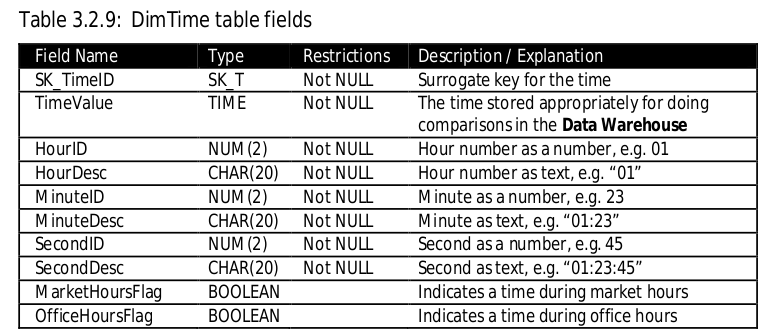

In [26]:
Image(filename="./pic/DimTime.png")

In [27]:
DimTime_schema = StructType([
    StructField("SK_TimeID", IntegerType(), False),
    StructField("TimeValue", StringType(), False),
    StructField("HourID", IntegerType(), False),
    StructField("HourDesc", StringType(), False),
    StructField("MinuteID", IntegerType(), False),
    StructField("MinuteDesc", StringType(), False),
    StructField("SecondID", IntegerType(), False),
    StructField("SecondDesc", StringType(), False),
    StructField("MarketHoursFlag", BooleanType()),
    StructField("OfficeHoursFlag", BooleanType()),
])

DimTime = spark.read\
            .format("csv")\
            .option("delimiter", "|") \
            .schema(DimTime_schema) \
            .load("./Batch1/Time.txt")

In [28]:
DimTime.printSchema()

root
 |-- SK_TimeID: integer (nullable = true)
 |-- TimeValue: string (nullable = true)
 |-- HourID: integer (nullable = true)
 |-- HourDesc: string (nullable = true)
 |-- MinuteID: integer (nullable = true)
 |-- MinuteDesc: string (nullable = true)
 |-- SecondID: integer (nullable = true)
 |-- SecondDesc: string (nullable = true)
 |-- MarketHoursFlag: boolean (nullable = true)
 |-- OfficeHoursFlag: boolean (nullable = true)



### DimDate

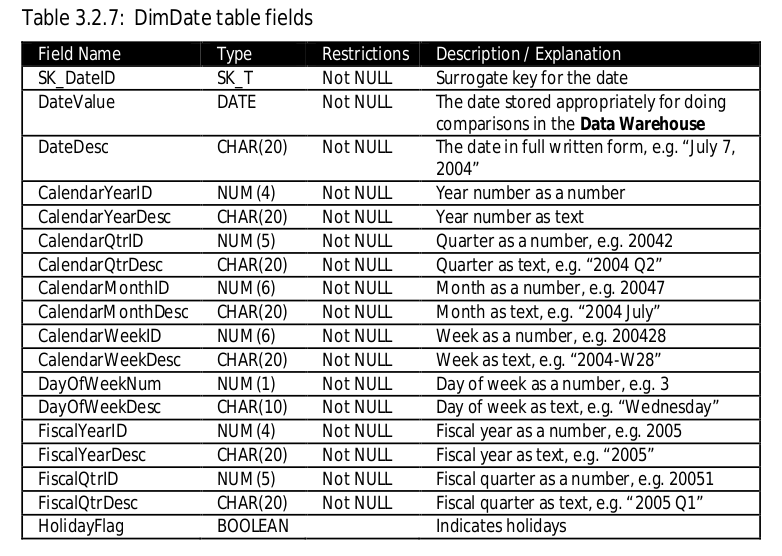

In [29]:
Image(filename="./pic/DimDate.png")

In [30]:
DimDate_schema = StructType([
    StructField("SK_DateID", IntegerType(), False),
    StructField("DateValue", DateType(), False),
    StructField("DateDesc", StringType(), False),
    StructField("CalendarYearID", IntegerType(), False),
    StructField("CalendarYearDesc", StringType(), False),
    StructField("CalendarQtrID", IntegerType(), False),
    StructField("CalendarQtrDesc", StringType(), False),
    StructField("CalendarMonthID", IntegerType(), False),
    StructField("CalendarMonthDesc", StringType(), False),
    StructField("CalendarWeekID", IntegerType(), False),
    StructField("CalendarWeekDesc", StringType(), False),
    StructField("DayOfWeekNum", IntegerType(), False),
    StructField("DayOfWeekDesc", StringType(), False),
    StructField("FiscalYearID", IntegerType(), False),
    StructField("FiscalYearDesc", StringType(), False),
    StructField("FiscalQtrID", IntegerType(), False),
    StructField("FiscalQtrDesc", StringType(), False),
    StructField("HolidayFlag", BooleanType()),
])

DimDate = spark.read\
            .format("csv")\
            .option("delimiter", "|") \
            .schema(DimDate_schema) \
            .load("./Batch1/Date.txt")

In [31]:
DimDate.printSchema()

root
 |-- SK_DateID: integer (nullable = true)
 |-- DateValue: date (nullable = true)
 |-- DateDesc: string (nullable = true)
 |-- CalendarYearID: integer (nullable = true)
 |-- CalendarYearDesc: string (nullable = true)
 |-- CalendarQtrID: integer (nullable = true)
 |-- CalendarQtrDesc: string (nullable = true)
 |-- CalendarMonthID: integer (nullable = true)
 |-- CalendarMonthDesc: string (nullable = true)
 |-- CalendarWeekID: integer (nullable = true)
 |-- CalendarWeekDesc: string (nullable = true)
 |-- DayOfWeekNum: integer (nullable = true)
 |-- DayOfWeekDesc: string (nullable = true)
 |-- FiscalYearID: integer (nullable = true)
 |-- FiscalYearDesc: string (nullable = true)
 |-- FiscalQtrID: integer (nullable = true)
 |-- FiscalQtrDesc: string (nullable = true)
 |-- HolidayFlag: boolean (nullable = true)



In [32]:
DimDate.show(5)

+---------+----------+---------------+--------------+----------------+-------------+---------------+---------------+-----------------+--------------+----------------+------------+-------------+------------+--------------+-----------+-------------+-----------+
|SK_DateID| DateValue|       DateDesc|CalendarYearID|CalendarYearDesc|CalendarQtrID|CalendarQtrDesc|CalendarMonthID|CalendarMonthDesc|CalendarWeekID|CalendarWeekDesc|DayOfWeekNum|DayOfWeekDesc|FiscalYearID|FiscalYearDesc|FiscalQtrID|FiscalQtrDesc|HolidayFlag|
+---------+----------+---------------+--------------+----------------+-------------+---------------+---------------+-----------------+--------------+----------------+------------+-------------+------------+--------------+-----------+-------------+-----------+
| 19500101|1950-01-01|January 1, 1950|          1950|            1950|        19501|        1950 Q1|          19501|     1950 January|         19501|         1950-W1|           7|       Sunday|        1950|          1950

### DimBroker

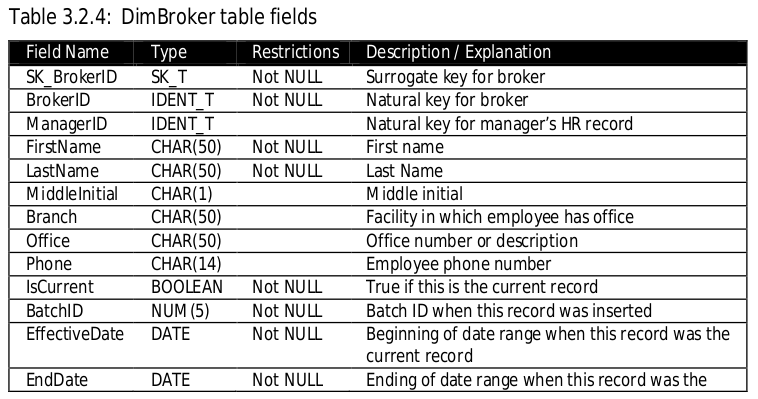

In [33]:
Image(filename="./pic/DimBroker.png")

In [34]:
StagingHR_schema = StructType([
    StructField("EmployeeID", IntegerType(), False),
    StructField("ManagerID", IntegerType(), False),
    StructField("EmployeeFirstName", StringType(), False),
    StructField("EmployeeLastName", StringType(), False),
    StructField("EmployeeMI", StringType()),
    StructField("EmployeeJobCode", IntegerType()),
    StructField("EmployeeBranch", StringType()),
    StructField("EmployeeOffice", StringType()),
    StructField("EmployeePhone", StringType()),
])

StagingHR = spark.read\
                .format("csv")\
                .option('header', 'false') \
                .schema(StagingHR_schema) \
                .load("./Batch1/HR.csv")

In [35]:
print(StagingHR.count())
StagingHR.printSchema()

50000
root
 |-- EmployeeID: integer (nullable = true)
 |-- ManagerID: integer (nullable = true)
 |-- EmployeeFirstName: string (nullable = true)
 |-- EmployeeLastName: string (nullable = true)
 |-- EmployeeMI: string (nullable = true)
 |-- EmployeeJobCode: integer (nullable = true)
 |-- EmployeeBranch: string (nullable = true)
 |-- EmployeeOffice: string (nullable = true)
 |-- EmployeePhone: string (nullable = true)



In [36]:
StagingHR.show(5)

+----------+---------+-----------------+----------------+----------+---------------+--------------------+--------------+--------------+
|EmployeeID|ManagerID|EmployeeFirstName|EmployeeLastName|EmployeeMI|EmployeeJobCode|      EmployeeBranch|EmployeeOffice| EmployeePhone|
+----------+---------+-----------------+----------------+----------+---------------+--------------------+--------------+--------------+
|         0|      702|            Ozkan|         Douglas|      null|            647|EGZKSobTeknHCbLuH...|    OFFICE7152|(726) 088-3331|
|         1|     1377|             Suer|         Candice|      null|            314|OfOBVvpzNvHCebxyu...|    OFFICE8586|(344) 999-2652|
|         2|      819|        Somisetty|            Jami|         P|            534|rAHWYkktOXAyPAYHl...|          null|(984) 538-5366|
|         3|      824|          Mazurek|       Rosalinda|         J|            364|TJQqsUQQGqWG QleL...|    OFFICE8487|(860) 037-6897|
|         4|     4345|        Aronovich|        

In [37]:
StagingBroker = StagingHR.where('EmployeeJobCode == 314') \
                        .withColumn('SK_BrokerID', StagingHR.EmployeeID) \
                        .withColumn('IsCurrent', lit(True).cast(BooleanType())) \
                        .withColumn('BatchID', lit(1).cast(IntegerType())) \
                        .withColumn('EffectiveDate', lit(BatchDate).cast(DateType())) \
                        .withColumn('EndDate', lit('9999-12-31').cast(DateType())) \
                        .withColumnRenamed('EmployeeID', 'BrokerID') \
                        .withColumnRenamed('EmployeeFirstName', 'FirstName') \
                        .withColumnRenamed('EmployeeLastName', 'LastName') \
                        .withColumnRenamed('EmployeeMI', 'MiddleInitial') \
                        .withColumnRenamed('EmployeeBranch', 'Branch') \
                        .withColumnRenamed('EmployeeOffice', 'Office') \
                        .withColumnRenamed('EmployeePhone', 'Phone') \
                        .drop('EmployeeJobCode')

In [38]:
print(StagingBroker.count())
StagingBroker.printSchema()

14239
root
 |-- BrokerID: integer (nullable = true)
 |-- ManagerID: integer (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- MiddleInitial: string (nullable = true)
 |-- Branch: string (nullable = true)
 |-- Office: string (nullable = true)
 |-- Phone: string (nullable = true)
 |-- SK_BrokerID: integer (nullable = true)
 |-- IsCurrent: boolean (nullable = false)
 |-- BatchID: integer (nullable = false)
 |-- EffectiveDate: date (nullable = true)
 |-- EndDate: date (nullable = true)



In [39]:
StagingBroker.show(5)

+--------+---------+----------+--------+-------------+--------------------+----------+--------------+-----------+---------+-------+-------------+----------+
|BrokerID|ManagerID| FirstName|LastName|MiddleInitial|              Branch|    Office|         Phone|SK_BrokerID|IsCurrent|BatchID|EffectiveDate|   EndDate|
+--------+---------+----------+--------+-------------+--------------------+----------+--------------+-----------+---------+-------+-------------+----------+
|       1|     1377|      Suer| Candice|         null|OfOBVvpzNvHCebxyu...|OFFICE8586|(344) 999-2652|          1|     true|      1|   2017-07-07|9999-12-31|
|       4|     4345| Aronovich|Delphine|            M|IEMJHuQgCPDHCwwJk...|OFFICE9420|(604) 387-9350|          4|     true|      1|   2017-07-07|9999-12-31|
|       8|     2146|    Hansen|Montreal|            T|sGIpORbLsRjTdhqBN...|OFFICE6343|(991) 491-4907|          8|     true|      1|   2017-07-07|9999-12-31|
|      11|     2259|Charchanko|  Sheela|         null|Cw Q

In [40]:
DimBroker = StagingBroker

### DimCustomer

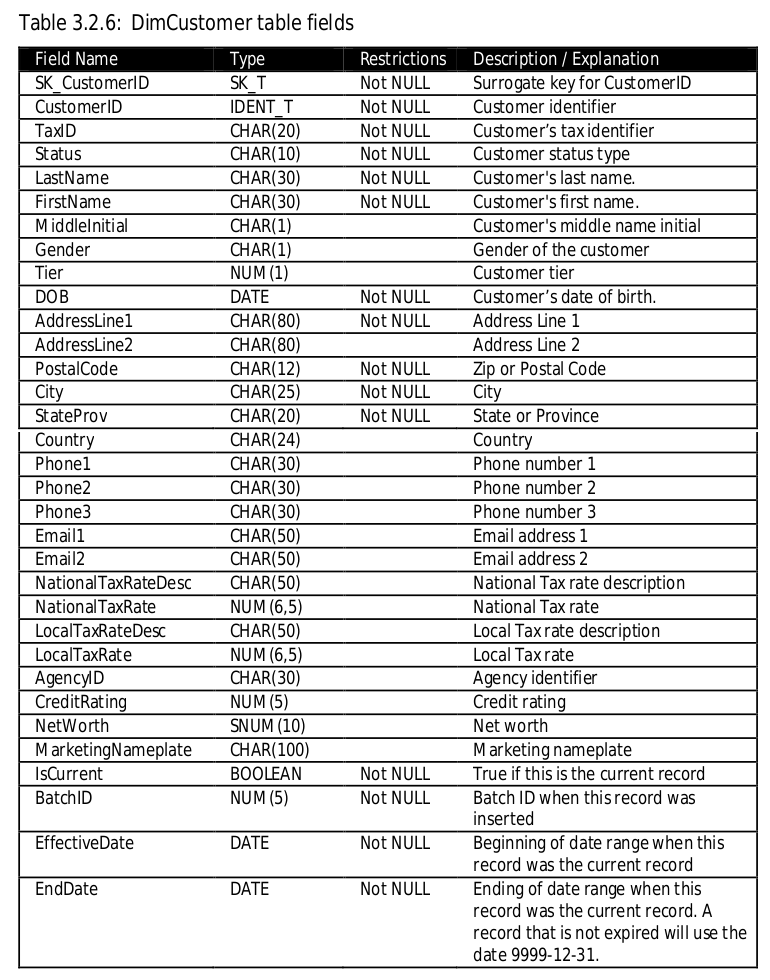

In [41]:
Image(filename="./pic/DimCustomer.png")

#### Get New Customers

In [42]:
Customer_new = StagingCustomerManagement \
                    .where(StagingCustomerManagement.ActionType == 'NEW')

In [43]:
print(Customer_new.count())
Customer_new.printSchema()

15280
root
 |-- ActionType: string (nullable = true)
 |-- SK_CustomerID: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- TaxID: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- MiddleInitial: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tier: string (nullable = true)
 |-- DOB: string (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- AddressLine2: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- StateProv: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Phone1: string (nullable = true)
 |-- Phone2: string (nullable = true)
 |-- Phone3: string (nullable = true)
 |-- Email1: string (nullable = true)
 |-- Email2: string (nullable = true)
 |-- C_NAT_TX_ID: string (nullable = true)
 |-- C_LCL_TX_ID: string (nullable = true)
 |-- AccountID: integer (nullable = true)
 |-- TaxStatus: intege

#### Update Customers Data

In [44]:
Customer_updates = StagingCustomerManagement \
                        .where(StagingCustomerManagement.ActionType == 'UPDCUST')

Customer_updated = Customer_new \
                        .alias("CstNew") \
                        .coalesce(1) \
                        .join(Customer_updates, ['CustomerID'], 'left') \
                        .select(
                            Customer_new.SK_CustomerID,
                            Customer_new.CustomerID,
                            coalesce(Customer_updates.TaxID, Customer_new.TaxID).alias("TaxID"),
                            coalesce(Customer_updates.LastName, Customer_new.LastName).alias("LastName"), 
                            coalesce(Customer_updates.FirstName, Customer_new.FirstName).alias("FirstName"), 
                            coalesce(Customer_updates.MiddleInitial, Customer_new.MiddleInitial).alias("MiddleInitial"), 
                            coalesce(Customer_updates.Gender, Customer_new.Gender).alias("Gender"), 
                            coalesce(Customer_updates.Tier, Customer_new.Tier).alias("Tier"), 
                            coalesce(Customer_updates.DOB, Customer_new.DOB).alias("DOB"), 
                            coalesce(Customer_updates.AddressLine1, Customer_new.AddressLine1).alias("AddressLine1"), 
                            coalesce(Customer_updates.AddressLine2, Customer_new.AddressLine2).alias("AddressLine2"), 
                            coalesce(Customer_updates.PostalCode, Customer_new.PostalCode).alias("PostalCode"), 
                            coalesce(Customer_updates.City, Customer_new.City).alias("City"), 
                            coalesce(Customer_updates.StateProv, Customer_new.StateProv).alias("StateProv"), 
                            coalesce(Customer_updates.Country, Customer_new.Country).alias("Country"), 
                            coalesce(Customer_updates.Phone1, Customer_new.Phone1).alias("Phone1"), 
                            coalesce(Customer_updates.Phone2, Customer_new.Phone2).alias("Phone2"), 
                            coalesce(Customer_updates.Phone3, Customer_new.Phone3).alias("Phone3"), 
                            coalesce(Customer_updates.Email1, Customer_new.Email1).alias("Email1"), 
                            coalesce(Customer_updates.Email2, Customer_new.Email2).alias("Email2"), 
                            coalesce(Customer_updates.C_NAT_TX_ID, Customer_new.C_NAT_TX_ID).alias("C_NAT_TX_ID"), 
                            coalesce(Customer_updates.C_LCL_TX_ID, Customer_new.C_LCL_TX_ID).alias("C_LCL_TX_ID")) \
                        .distinct() 


In [45]:
print(Customer_updated.count())
Customer_updated.printSchema()

15280
root
 |-- SK_CustomerID: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- TaxID: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- MiddleInitial: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tier: string (nullable = true)
 |-- DOB: string (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- AddressLine2: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- StateProv: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Phone1: string (nullable = true)
 |-- Phone2: string (nullable = true)
 |-- Phone3: string (nullable = true)
 |-- Email1: string (nullable = true)
 |-- Email2: string (nullable = true)
 |-- C_NAT_TX_ID: string (nullable = true)
 |-- C_LCL_TX_ID: string (nullable = true)



#### Update Inactive Customer status

In [46]:
Customer_inactives = StagingCustomerManagement \
                        .where(StagingCustomerManagement.ActionType == 'INACT') \
                        .select('CustomerID') \
                        .withColumn('Status', lit("INACTIVE"))

In [47]:
Customer_inact_updated = Customer_updated \
                            .join(Customer_inactives, ['CustomerID'], 'left') \
                            .select(Customer_updated.columns + [coalesce(Customer_inactives.Status, lit("ACTIVE")).alias("Status")]) \
                            .persist()

In [48]:
print(Customer_inact_updated.count())
Customer_inact_updated.printSchema()

15280
root
 |-- SK_CustomerID: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- TaxID: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- MiddleInitial: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tier: string (nullable = true)
 |-- DOB: string (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- AddressLine2: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- StateProv: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Phone1: string (nullable = true)
 |-- Phone2: string (nullable = true)
 |-- Phone3: string (nullable = true)
 |-- Email1: string (nullable = true)
 |-- Email2: string (nullable = true)
 |-- C_NAT_TX_ID: string (nullable = true)
 |-- C_LCL_TX_ID: string (nullable = true)
 |-- Status: string (nullable = false)



#### Join with TaxRate to populate the remaining data

In [49]:
StagingCustomer = Customer_inact_updated \
                    .join(
                        broadcast(TaxRate).alias("NationalTax"),
                        Customer_inact_updated.C_NAT_TX_ID == TaxRate.TX_ID,
                        "left") \
                    .withColumnRenamed("TX_NAME", "NationalTaxRateDesc") \
                    .withColumnRenamed("TX_RATE", "NationalTaxRate") \
                    .drop('C_NAT_TX_ID', 'TX_ID')

StagingCustomer = StagingCustomer.join(
                        broadcast(TaxRate).alias("LocalTax"),
                        StagingCustomer.C_LCL_TX_ID == TaxRate.TX_ID,
                        "left") \
                    .withColumnRenamed("TX_NAME", "LocalTaxRateDesc") \
                    .withColumnRenamed("TX_RATE", "LocalTaxRate") \
                    .drop('C_LCL_TX_ID', 'TX_ID')
                    

In [50]:
print(StagingCustomer.count())
StagingCustomer.printSchema()

15280
root
 |-- SK_CustomerID: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- TaxID: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- MiddleInitial: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tier: string (nullable = true)
 |-- DOB: string (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- AddressLine2: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- StateProv: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Phone1: string (nullable = true)
 |-- Phone2: string (nullable = true)
 |-- Phone3: string (nullable = true)
 |-- Email1: string (nullable = true)
 |-- Email2: string (nullable = true)
 |-- Status: string (nullable = false)
 |-- NationalTaxRateDesc: string (nullable = true)
 |-- NationalTaxRate: float (nullable = true)
 |-- LocalTaxRateDesc: string (nullable = true)
 |-- Loc

#### Join with Prospect to populate the remaining data

In [51]:
StagingCustomer = StagingCustomer \
                    .alias('StagingCustomer') \
                    .join(
                        Prospect,
                        [
                            upper(StagingCustomer.LastName) == upper(Prospect.LastName),
                            upper(StagingCustomer.FirstName) == upper(Prospect.FirstName),
                            upper(StagingCustomer.AddressLine1) == upper(Prospect.AddressLine1),
                            upper(StagingCustomer.AddressLine2) == upper(Prospect.AddressLine2),
                            upper(StagingCustomer.PostalCode) == upper(Prospect.PostalCode)
                        ],
                        'left') \
                    .select(
                        ['StagingCustomer.'+i for i in StagingCustomer.columns] + \
                        [
                            Prospect.AgencyID,
                            Prospect.CreditRating,
                            Prospect.NetWorth,
                            Prospect.MarketingNameplate
                        ]) 

In [52]:
print(StagingCustomer.count())
StagingCustomer.printSchema()

15280
root
 |-- SK_CustomerID: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- TaxID: string (nullable = true)
 |-- LastName: string (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- MiddleInitial: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tier: string (nullable = true)
 |-- DOB: string (nullable = true)
 |-- AddressLine1: string (nullable = true)
 |-- AddressLine2: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- StateProv: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Phone1: string (nullable = true)
 |-- Phone2: string (nullable = true)
 |-- Phone3: string (nullable = true)
 |-- Email1: string (nullable = true)
 |-- Email2: string (nullable = true)
 |-- Status: string (nullable = false)
 |-- NationalTaxRateDesc: string (nullable = true)
 |-- NationalTaxRate: float (nullable = true)
 |-- LocalTaxRateDesc: string (nullable = true)
 |-- Loc

In [53]:
StagingCustomer = StagingCustomer \
                    .withColumn('IsCurrent', lit(True).cast(BooleanType())) \
                    .withColumn('BatchID', lit(1).cast(IntegerType())) \
                    .withColumn('EffectiveDate', lit(BatchDate).cast(DateType())) \
                    .withColumn('EndDate', lit('9999-12-31').cast(DateType())) \

In [54]:
DimCustomer = StagingCustomer

### DimAccount

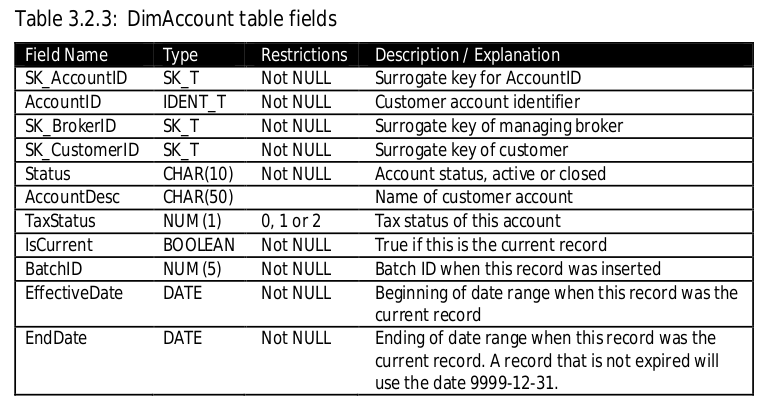

In [55]:
Image(filename="./pic/DimAccount.png")

#### Get new accounts

In [56]:
Account_new = StagingCustomerManagement \
                    .where(
                        (StagingCustomerManagement.ActionType == "NEW") | \
                        (StagingCustomerManagement.ActionType == "ADDACCT")) \
                    .withColumn("SK_AccountID", StagingCustomerManagement.AccountID) \
                    .select([
                        "SK_AccountID",
                        "AccountID",
                        "SK_CustomerID",
                        "AccountDesc",
                        "TaxStatus",
                        "BrokerID"
                    ])

In [57]:
print(Account_new.count())
Account_new.printSchema()

30470
root
 |-- SK_AccountID: integer (nullable = true)
 |-- AccountID: integer (nullable = true)
 |-- SK_CustomerID: integer (nullable = true)
 |-- AccountDesc: string (nullable = true)
 |-- TaxStatus: integer (nullable = true)
 |-- BrokerID: integer (nullable = true)



#### Update Accounts

In [58]:
Account_updates = StagingCustomerManagement \
                            .where(StagingCustomerManagement.ActionType == "UPDACCT")

Account_updated = Account_new \
                        .alias("AccNew") \
                        .coalesce(1) \
                        .join(Account_updates, ["AccountID"], "left") \
                        .select(
                            Account_new.SK_AccountID,
                            Account_new.AccountID,
                            Account_new.SK_CustomerID,
                            coalesce(Account_updates.AccountDesc, Account_new.AccountDesc).alias("AccountDesc"),
                            coalesce(Account_updates.TaxStatus, Account_new.TaxStatus).alias("TaxStatus"),
                            coalesce(Account_updates.BrokerID, Account_new.BrokerID).alias("BrokerID"),
                        ) \
                        .distinct()


In [59]:
print(Account_updated.count())
Account_updated.printSchema()

30470
root
 |-- SK_AccountID: integer (nullable = true)
 |-- AccountID: integer (nullable = true)
 |-- SK_CustomerID: integer (nullable = true)
 |-- AccountDesc: string (nullable = true)
 |-- TaxStatus: integer (nullable = true)
 |-- BrokerID: integer (nullable = true)



#### Update Inactive Accounts

In [60]:
Account_inactives = StagingCustomerManagement \
                        .where((StagingCustomerManagement.ActionType == 'INACT') | \
                                  (StagingCustomerManagement.ActionType == 'CLOSEACCT')) \
                        .select('AccountID') \
                        .withColumn('Status', lit("INACTIVE"))

In [61]:
Account_inact_updated = Account_updated \
                            .join(Account_inactives, ['AccountID'], 'left') \
                            .select(Account_updated.columns + [coalesce(Account_inactives.Status, lit("ACTIVE")).alias("Status")]) \
                            .persist()

In [62]:
print(Account_inact_updated.count())
Account_inact_updated.printSchema()

30470
root
 |-- SK_AccountID: integer (nullable = true)
 |-- AccountID: integer (nullable = true)
 |-- SK_CustomerID: integer (nullable = true)
 |-- AccountDesc: string (nullable = true)
 |-- TaxStatus: integer (nullable = true)
 |-- BrokerID: integer (nullable = true)
 |-- Status: string (nullable = false)



#### Join with DimBroker to get SK_BrokerID
We assumed that SK_BrokerID will be same as BrokerID but we will make the join

In [63]:
StagingAccount = Account_inact_updated \
                        .join(DimBroker, ["BrokerID"], "left") \
                        .select(Account_inact_updated.columns + [DimBroker.SK_BrokerID]) \
                        .drop("BrokerID") \
                        .withColumn('IsCurrent', lit(True).cast(BooleanType())) \
                        .withColumn('BatchID', lit(1).cast(IntegerType())) \
                        .withColumn('EffectiveDate', lit(BatchDate).cast(DateType())) \
                        .withColumn('EndDate', lit('9999-12-31').cast(DateType())) \

In [64]:
print(StagingAccount.count())
StagingAccount.printSchema()

30470
root
 |-- SK_AccountID: integer (nullable = true)
 |-- AccountID: integer (nullable = true)
 |-- SK_CustomerID: integer (nullable = true)
 |-- AccountDesc: string (nullable = true)
 |-- TaxStatus: integer (nullable = true)
 |-- Status: string (nullable = false)
 |-- SK_BrokerID: integer (nullable = true)
 |-- IsCurrent: boolean (nullable = false)
 |-- BatchID: integer (nullable = false)
 |-- EffectiveDate: date (nullable = true)
 |-- EndDate: date (nullable = true)



In [65]:
DimAccount = StagingAccount

## Preparing Warehouse Fact tables

### FactCashBalances

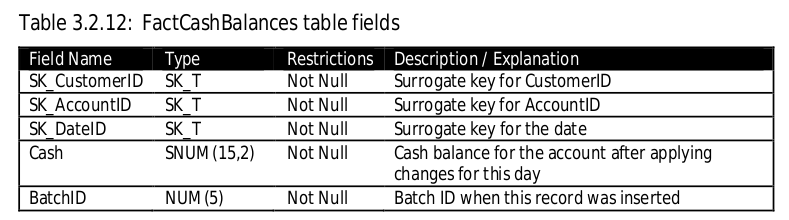

In [66]:
Image(filename="./pic/FactCashBalances.png")

#### Create CashTransaction table

In [67]:
CashTransaction_schema = StructType([
    StructField("CT_CA_ID", IntegerType(), False),
    StructField("CT_DTS", StringType(), False),
    StructField("CT_AMT", FloatType(), False),
    StructField("CT_NAME", StringType(), False),
])

CashTransaction = spark.read\
                    .format("csv")\
                    .option("delimiter", "|") \
                    .schema(CashTransaction_schema) \
                    .load("./Batch1/CashTransaction.txt")

In [68]:
print(CashTransaction.count())
CashTransaction.printSchema()

1203664
root
 |-- CT_CA_ID: integer (nullable = true)
 |-- CT_DTS: string (nullable = true)
 |-- CT_AMT: float (nullable = true)
 |-- CT_NAME: string (nullable = true)



In [69]:
CashTransaction.show(5)

+--------+-------------------+---------+--------------------+
|CT_CA_ID|             CT_DTS|   CT_AMT|             CT_NAME|
+--------+-------------------+---------+--------------------+
|       3|2012-07-11 08:09:52|-37215.14|TGDRsaHPherhApDuH...|
|      52|2012-07-07 17:08:29| -3178.67|PGwhaPC igAVOmHLJ...|
|      55|2012-07-12 17:34:13| -3172.19|uQOUlrpDGHQpeeBGx...|
|      61|2012-09-20 03:07:49| -16621.0|VRIGhrJYHmbmNyXtI...|
|      28|2012-07-09 07:26:05|  -1315.7|gySbOpZLevgVdfrrw...|
+--------+-------------------+---------+--------------------+
only showing top 5 rows



In [70]:
StagingCashBalance = CashTransaction \
                        .coalesce(1) \
                        .join(broadcast(DimDate), DimDate.DateValue == CashTransaction.CT_DTS.cast(DateType())) \
                        .join(DimAccount, CashTransaction.CT_CA_ID == DimAccount.AccountID) \
                        .select(CashTransaction.columns + [DimDate.SK_DateID, DimAccount.SK_AccountID, DimAccount.SK_CustomerID]) \
                        .drop("CT_CA_ID", "CT_DTS", "CT_NAME") \
                        .persist()

In [71]:
print(StagingCashBalance.count())
StagingCashBalance.printSchema()

1203664
root
 |-- CT_AMT: float (nullable = true)
 |-- SK_DateID: integer (nullable = true)
 |-- SK_AccountID: integer (nullable = true)
 |-- SK_CustomerID: integer (nullable = true)



In [72]:
StagingCashBalance.show(5)

+---------+---------+------------+-------------+
|   CT_AMT|SK_DateID|SK_AccountID|SK_CustomerID|
+---------+---------+------------+-------------+
|-707905.1| 20120718|         148|            6|
| -3730.49| 20120808|         148|            6|
|  7781.84| 20120808|         148|            6|
| -6221.87| 20121006|         148|            6|
|-63388.52| 20121004|         148|            6|
+---------+---------+------------+-------------+
only showing top 5 rows



#### Make aggregation for cash groubing by SK_DateID and SK_AccountID

In [73]:
CashBalances = StagingCashBalance \
                    .groupBy("SK_DateID", "SK_AccountID", "SK_CustomerID") \
                    .agg({"CT_AMT": "sum"}) \
                    .withColumnRenamed("sum(CT_AMT)", "Cash") \
                    .withColumn('BatchID', lit(1).cast(IntegerType()))

In [74]:
print(CashBalances.count())
CashBalances.printSchema()

1087041
root
 |-- SK_DateID: integer (nullable = true)
 |-- SK_AccountID: integer (nullable = true)
 |-- SK_CustomerID: integer (nullable = true)
 |-- Cash: double (nullable = true)
 |-- BatchID: integer (nullable = false)



In [75]:
CashBalances.show(5)

+---------+------------+-------------+-----------------+-------+
|SK_DateID|SK_AccountID|SK_CustomerID|             Cash|BatchID|
+---------+------------+-------------+-----------------+-------+
| 20130526|         463|          288|    77277.7109375|      1|
| 20121026|         471|          296|3453.800048828125|      1|
| 20120904|         496|          187|   39866.76171875|      1|
| 20121129|         496|          187|-10099.3798828125|      1|
| 20130726|         833|           30|   9741.419921875|      1|
+---------+------------+-------------+-----------------+-------+
only showing top 5 rows



In [76]:
FactCashBalances = CashBalances

## Saving Dimintion tables and Fact tables

In [77]:
DimTime.write.parquet("DimTime.parquet", "overwrite")

In [78]:
DimDate.write.parquet("DimDate.parquet", "overwrite")

In [79]:
DimCustomer.write.parquet("DimCustomer.parquet", "overwrite")

In [80]:
DimAccount.write.parquet("DimAccount.parquet", "overwrite")

In [81]:
FactCashBalances.write.parquet("FactCashBalances.parquet", "overwrite")

## Unpersist the stored Dataframes

In [82]:
StagingCashBalance.unpersist()
Customer_inact_updated.unpersist()
StagingCustomerManagement.unpersist()

DataFrame[ActionType: string, SK_CustomerID: int, CustomerID: int, TaxID: string, LastName: string, FirstName: string, MiddleInitial: string, Gender: string, Tier: string, DOB: string, AddressLine1: string, AddressLine2: string, PostalCode: string, City: string, StateProv: string, Country: string, Phone1: string, Phone2: string, Phone3: string, Email1: string, Email2: string, C_NAT_TX_ID: string, C_LCL_TX_ID: string, AccountID: int, TaxStatus: int, AccountDesc: string, BrokerID: int]

# Data Warehouse area

## Read the tables from Parquet Files

In [83]:
DimDateParquetFile = spark.read.parquet("DimDate.parquet")
DimDateParquetFile.createOrReplaceTempView("DimDate")

In [84]:
DimCustomerParquetFile = spark.read.parquet("DimCustomer.parquet")
DimCustomerParquetFile.createOrReplaceTempView("DimCustomer")

In [85]:
DimAccountParquetFile = spark.read.parquet("DimAccount.parquet")
DimAccountParquetFile.createOrReplaceTempView("DimAccount")

In [86]:
FactCashBalancesParquetFile = spark.read.parquet("FactCashBalances.parquet")
FactCashBalancesParquetFile.createOrReplaceTempView("FactCashBalances")

## Question 1
Get the sum of transactions per customer for the first quarter of year 2017

In [87]:
sumPerCustQ1Y2012 = spark.sql(
    "SELECT DimCustomer.SK_CustomerID, DimCustomer.LastName, DimCustomer.FirstName, sum(Cash) AS Sum_of_Transactions \
        FROM FactCashBalances \
        JOIN DimDate ON DimDate.SK_DateID = FactCashBalances.SK_DateID \
        JOIN DimCustomer ON DimCustomer.SK_CustomerID = FactCashBalances.SK_CustomerID \
        WHERE DimDate.CalendarQtrID = '20171' \
        GROUP BY DimCustomer.SK_CustomerID, DimCustomer.LastName, DimCustomer.FirstName \
    ")

In [88]:
sumPerCustQ1Y2012.show()

+-------------+-----------------+---------+-------------------+
|SK_CustomerID|         LastName|FirstName|Sum_of_Transactions|
+-------------+-----------------+---------+-------------------+
|         5223|            Irvin|  Thi-cuc| -46031.38269042969|
|         1331|          Schmitt|  Christy| 2525713.0228271484|
|         3439|KleynenbergNTACFB|  Chrissy| -887628.4156494141|
|         5654|             Kaya|       Ru|   87095.6181640625|
|         6066|          Donohoe|    Alexi| -964843.8388671875|
|          667|      Abou-Arrage|     Chun|-164431.85522460938|
|           70|             Lund|   Roxine| -1118027.845703125|
|         2453|            Roper|    Dinah| 1968314.1256103516|
|         5470|          Shostak|    Cassy| -26863.94287109375|
|         3313|            Jamal|    Nancy| -333936.1563720703|
|         4381|          Zylstra|    Robbi|  389164.4736328125|
|         3238|          McNamee|  Fidelia|-2793880.6506347656|
|         1130|              Jee|    Gra

## Question 2
Get max transaction amount per quarter

In [89]:
maxPerQuar = spark.sql(
    "SELECT DimDate.CalendarQtrDesc, max(Cash) AS Max_Transaction_Amount \
        FROM FactCashBalances \
        JOIN DimDate ON DimDate.SK_DateID = FactCashBalances.SK_DateID \
        GROUP BY DimDate.CalendarQtrDesc \
    ")

In [90]:
maxPerQuar.show()

+---------------+----------------------+
|CalendarQtrDesc|Max_Transaction_Amount|
+---------------+----------------------+
|        2015 Q1|    1560418.6997070312|
|        2013 Q3|          1828547.5625|
|        2013 Q4|    1842804.3674316406|
|        2017 Q1|            1687340.25|
|        2012 Q3|    1942700.9150390625|
|        2013 Q2|    1814121.9074707031|
|        2014 Q2|          1678093.5625|
|        2016 Q4|    1847979.4125976562|
|        2017 Q3|         1078888.46875|
|        2016 Q3|          1244228.5625|
|        2017 Q2|           1780737.625|
|        2014 Q3|          1552390.9375|
|        2013 Q1|          1730115.8125|
|        2014 Q1|           1860174.375|
|        2015 Q4|         1411393.28125|
|        2012 Q4|    1919910.8149414062|
|        2015 Q2|          1479007.6875|
|        2014 Q4|            1864987.75|
|        2015 Q3|       1614920.8203125|
|        2016 Q1|          1601916.0625|
+---------------+----------------------+
only showing top

## Question 3
For a specific customer ID, get the total amounts of transactions per week.

In [91]:
sumPerCustPerWeek = spark.sql(
    "SELECT DimCustomer.SK_CustomerID, DimCustomer.LastName, DimCustomer.FirstName, DimDate.CalendarWeekDesc, sum(Cash) AS Total_Transactions_Amount \
        FROM FactCashBalances \
        JOIN DimDate ON DimDate.SK_DateID = FactCashBalances.SK_DateID \
        JOIN DimCustomer ON DimCustomer.SK_CustomerID = FactCashBalances.SK_CustomerID \
        GROUP BY DimCustomer.SK_CustomerID, DimCustomer.LastName, DimCustomer.FirstName, DimDate.CalendarWeekDesc \
    ")

In [92]:
sumPerCustPerWeek.show()

+-------------+-----------------+---------+----------------+-------------------------+
|SK_CustomerID|         LastName|FirstName|CalendarWeekDesc|Total_Transactions_Amount|
+-------------+-----------------+---------+----------------+-------------------------+
|         1592|         Prattico|     Dany|        2013-W35|             544056.46875|
|          677|           Eisele|    Ayako|        2014-W13|      -140171.16748046875|
|         6205|Baggerman-Webster|   Rosana|        2016-W40|         8132.60009765625|
|          599|            Tiegs|Margarita|        2017-W14|        -5786.11962890625|
|          518|         DeSimone|     Wits|         2014-W1|       -80435.07153320312|
|           90|           Lehman|    Tommy|         2013-W9|       -867795.3493652344|
|          201|         Mullaney|    Heinz|         2013-W5|       -77453.04833984375|
|          672|      Maisonneuve|    Angel|        2013-W41|       -80267.30200195312|
|          601|             Absi|    Jonie|

# Stop Spark Session

In [93]:
spark.stop()